In [120]:
import torch
import numpy
import matplotlib.pyplot as plt

from dataset_mnist import *

from sklearn.manifold import TSNE

'''
simple CNN model
'''
class Model(torch.nn.Module):
    def __init__(self, input_shape, features_count):
        super(Model, self).__init__()

        fc_size = (input_shape[1]//4) * (input_shape[2]//4)

        self.model = torch.nn.Sequential(
            torch.nn.Conv2d(input_shape[0], 16, kernel_size=3, stride=1, padding=1),
            torch.nn.LeakyReLU(),
            
            torch.nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            torch.nn.LeakyReLU(), 
            
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            torch.nn.LeakyReLU(), 

            torch.nn.Flatten(),
             
            torch.nn.Linear(fc_size*64, features_count),
            torch.nn.LeakyReLU(), 

            torch.nn.Linear(features_count, features_count)
        )

        for i in range(len(self.model)):
            if hasattr(self.model[i], "weight"):
                torch.nn.init.orthogonal_(self.model[i].weight, 2**0.5)
                torch.nn.init.zeros_(self.model[i].bias)

    def forward(self, x): 
        return self.model(x) 
    



'''
random tile masking
'''
def aug_random_tiles(x, max_loops = 4, p_base=0.1): 
    loops   = numpy.random.randint(0, max_loops+1)

    p       = p_base/((2*loops + 1)**2)

    mask    = (torch.rand((x.shape[0], 1, x.shape[2], x.shape[3])) < p).float()

    pool    = torch.nn.MaxPool2d(3, stride=1, padding=1)

    for i in range(loops):
        mask = pool(mask)

    mask = (1.0 - mask.to(x.device))
    return x*mask



def aug_noise(x): 
    return x + 0.1*torch.randn_like(x)
   
def aug_inverse(x): 
    r = torch.randint(0, 2, (x.shape[0], x.shape[1])).unsqueeze(2).unsqueeze(3).to(x.device)
    return r*(1.0 - x) + (1.0 - r)*x
    

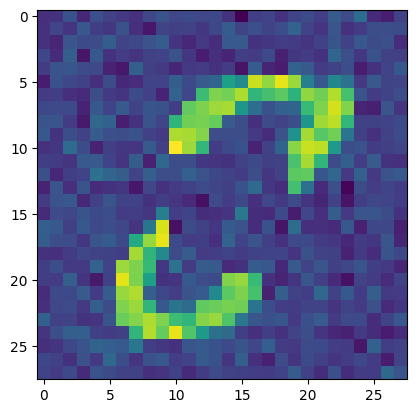

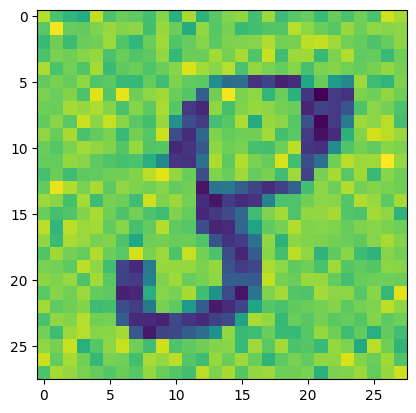

In [121]:
dataset = DatasetMnist()
batch_size = 128

x, y = dataset.get_batch(batch_size)

#augmented batch example
xa = aug_random_tiles(x)
xb = aug_random_tiles(x)

xa = aug_noise(xa)
xb = aug_noise(xb)

xa = aug_inverse(xa)
xb = aug_inverse(xb)

plt.imshow(xa[0][0].detach().cpu().numpy())
plt.show()
plt.imshow(xb[0][0].detach().cpu().numpy())
plt.show()


In [122]:
#create model
features_count = 256 
model = Model(dataset.input_shape, features_count)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print(model)

Model(
  (model): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.01)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=3136, out_features=256, bias=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Linear(in_features=256, out_features=256, bias=True)
  )
)


## vicreg loss - non contrastive self supervised loss

In [123]:
def _off_diagonal(x):
    mask = 1.0 - torch.eye(x.shape[0], device=x.device)
    return x*mask 

def vicreg_loss_func(za, zb):
    eps = 0.0001 
 
    # invariance loss
    sim_loss = ((za - zb)**2).mean()

    # variance loss
    std_za = torch.sqrt(za.var(dim=0) + eps)
    std_zb = torch.sqrt(zb.var(dim=0) + eps) 
    
    std_loss = torch.mean(torch.relu(1.0 - std_za)) 
    std_loss+= torch.mean(torch.relu(1.0 - std_zb))
   
    # covariance loss 
    za_norm = za - za.mean(dim=0)
    zb_norm = zb - zb.mean(dim=0)
    cov_za = (za_norm.T @ za_norm) / (za.shape[0] - 1.0)
    cov_zb = (zb_norm.T @ zb_norm) / (zb.shape[0] - 1.0)
    
    cov_loss = _off_diagonal(cov_za).pow_(2).sum()/za.shape[1] 
    cov_loss+= _off_diagonal(cov_zb).pow_(2).sum()/zb.shape[1]

    # total vicreg loss
    loss = 1.0*sim_loss + 1.0*std_loss + (1.0/25.0)*cov_loss

    return loss


In [124]:

'''
#training loos
steps_count = len(dataset)//batch_size
for i in range(steps_count):

    #get random batch
    x, _ = dataset.get_batch(batch_size)

    #create augmented inputs
    xa = aug_random_tiles(x)
    xb = aug_random_tiles(x)

    xa = aug_noise(xa)
    xb = aug_noise(xb)

    xa = aug_inverse(xa)
    xb = aug_inverse(xb)

    #obtain features
    za = model(xa)
    zb = model(xb)

    #compute loss
    loss = vicreg_loss_func(za, zb)

    #optimizer
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(i, steps_count, loss)

torch.save(model.state_dict(), "trained/model_mnist.pt")
'''

'\n#training loos\nsteps_count = len(dataset)//batch_size\nfor i in range(steps_count):\n\n    #get random batch\n    x, _ = dataset.get_batch(batch_size)\n\n    #create augmented inputs\n    xa = aug_random_tiles(x)\n    xb = aug_random_tiles(x)\n\n    xa = aug_noise(xa)\n    xb = aug_noise(xb)\n\n    xa = aug_inverse(xa)\n    xb = aug_inverse(xb)\n\n    #obtain features\n    za = model(xa)\n    zb = model(xb)\n\n    #compute loss\n    loss = vicreg_loss_func(za, zb)\n\n    #optimizer\n    optimizer.zero_grad()\n    loss.backward()\n    optimizer.step()\n\n    print(i, steps_count, loss)\n\ntorch.save(model.state_dict(), "trained/model_mnist.pt")\n'

## model testing for similarity detection

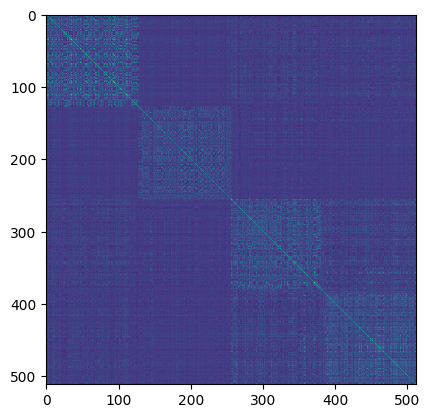

In [125]:

#create model and load weights
model = Model(dataset.input_shape, features_count)
model.load_state_dict(torch.load("trained/model_mnist.pt", map_location = "cpu"))
model.eval()


batch_size = 128

#sample only zeros from dataset
x0 = dataset.get_batch_class(batch_size, 0)

#sample only ones from dataset
x1 = dataset.get_batch_class(batch_size, 1)

#sample only sevens from dataset
x2 = dataset.get_batch_class(batch_size, 7)

#sample only nines from dataset
x3 = dataset.get_batch_class(batch_size, 9)


x = torch.concatenate([x0, x1, x2, x3], dim=0)

z = model(x) 

#vectors dot product, each by each
similarity = z@z.T

plt.imshow(similarity.detach().cpu().numpy())
plt.show()

## features projection


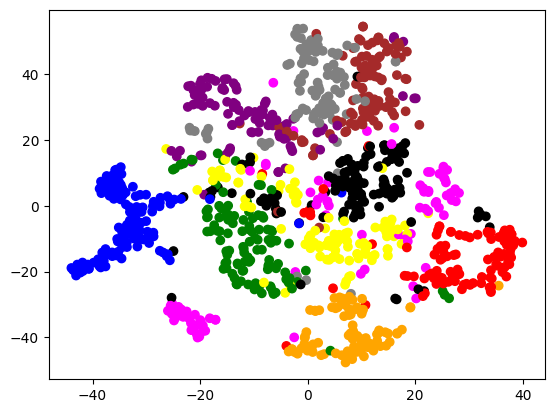

In [126]:
x, y = dataset.get_batch(1024)

y = y.detach().cpu().numpy()
y = numpy.array(y, dtype=int)

z = model(x) 

z = z.detach().cpu().numpy()

z_proj = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(z)


colormap = numpy.array(["red","blue","green","yellow","gray","magenta","orange","purple","black","brown"])

plt.scatter(z_proj[:, 0], z_proj[:, 1], c=colormap[y])
plt.show()